In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from src.caching import PointwiseRunFile, PairwiseFileCache
from tqdm.notebook import tqdm
import networkx as nx

In [4]:
sns.set_style({
    'axes.facecolor': 'white',
    'axes.edgecolor': '.05',
    'axes.grid': True,
    'axes.axisbelow': True,
    'axes.labelcolor': '.0',
    'figure.facecolor': 'white',
    'grid.color': '.75',
    'grid.linestyle': '-',
    'text.color': '.15',
    'xtick.color': '.05',
    'ytick.color': '.05',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial', 'Helvetica Neue', 'sans-serif'],
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
})
sns.set_context("talk")
palette = sns.color_palette([
  #"#be503e",
  "#7bb292",
  "#d7ae38",
  "#628b97"
])

In [5]:
COLLECTIONS = [
    "cw12",
    "dl-passages",
    "cw09"
]
MODELS = [
    "3b",
    #"base"
]
K = 50

# Score Distribution

In [4]:
data = []
for collection in COLLECTIONS:
    for model in MODELS:
        pointwise = PointwiseRunFile(f"../data/interim/pointwise/{collection}/mono_t5_{model}-run.txt")
        pairwise = PairwiseFileCache(
            f"../data/interim/pairwise/{collection}-{model}.parquet",
            depth=K,
            pointwise=pointwise
        )
        df = pairwise.cache.dropna().assign(collection=collection, model=model)
        df.score = df.score.apply(lambda x: np.exp(x))
        data.append(df)

df = pd.concat(data)

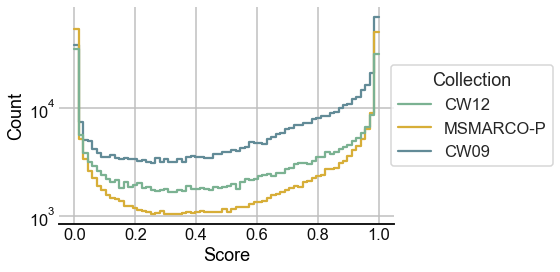

In [16]:
ax = sns.histplot(
    data=(
        df
        .drop(["qid", "id_a", "id_b"], axis=1)
        .reset_index(drop=True)
        .rename({"collection": "Collection", "score": "Score"}, axis=1)
        .replace({
            "cw12": "CW12",
            "dl-passages": "MSMARCO-P",
            "cw09": "CW09"
        })
    ),
    x="Score",
    hue="Collection",
    fill=False,
    element="step",
    common_norm=False,
    #cumulative=True,
    #stat="density",
    palette=palette,
)
ax.set_yscale('log')
sns.move_legend(ax, "center right", bbox_to_anchor=(1.5, 0.5))

ax.get_figure().savefig("../reports/figures/score-distribution.pdf")

# Transitivity

In [37]:
data = []
for collection in COLLECTIONS:
    for model in MODELS:
        pointwise = PointwiseRunFile(f"../data/interim/pointwise/{collection}/mono_t5_{model}-run.txt")
        pairwise = PairwiseFileCache(
            f"../data/interim/pairwise/{collection}-{model}.parquet",
            depth=K,
            pointwise=pointwise
        )
        df = pairwise.cache.dropna()
        df.score = df.score.apply(lambda x: np.exp(x))
        for qid in df.qid.unique():
            graph = nx.DiGraph()
            for _, (id_a, id_b, _, p) in df[df.qid == qid].iterrows():
                if p >= 0.5:
                    graph.add_edge(id_a, id_b)
                if p < 0.5:
                    graph.add_edge(id_b, id_a)
            t = nx.transitivity(graph)
            data.append((collection, model, qid, t))

/Users/gienapp/.local/share/virtualenvs/sigir22-pairwise-ranking-p5lkW2uP/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [38]:
print(
    pd.DataFrame(data, columns=["collection", "model", "qid", "transitivity"])
    .groupby(["collection", "model"])
    .describe()
    #.reset_index()
    #.droplevel(0, axis=1)
    #.swaplevel()
    #.set_index("collection", "model")
    #.loc[
    #    :,
    #    [ "mean", "std", "min", "max"]
    #]
    #.to_latex()
)

                  transitivity                                          \
                         count      mean       std       min       25%   
collection  model                                                        
cw09        3b           198.0  0.783811  0.079016  0.615723  0.724898   
cw12        3b           100.0  0.742149  0.064020  0.610847  0.692700   
dl-passages 3b            97.0  0.692809  0.073432  0.580233  0.632462   

                                                 
                        50%       75%       max  
collection  model                                
cw09        3b     0.785480  0.845354  0.953665  
cw12        3b     0.726258  0.787964  0.898295  
dl-passages 3b     0.672663  0.725557  0.901360  


# Antisymmetry

In [26]:
def _order_pair(id_a, id_b, p):
    if id_a >= id_b:
        return id_a, id_b, p
    else:
        return id_b, id_a, 1 - p

In [27]:
data = []

pbar = tqdm(total=len(COLLECTIONS)*len(MODELS))
for collection in COLLECTIONS:
    for model in MODELS:
        pbar.set_description(f"{collection}-{model}")
        pointwise = PointwiseRunFile(f"../data/interim/pointwise/{collection}/mono_t5_{model}-run.txt")
        pairwise = PairwiseFileCache(
            f"../data/interim/pairwise/{collection}-{model}.parquet",
            depth=K,
            pointwise=pointwise
        )
        df = pairwise.cache.dropna()
        df.score = df.score.apply(lambda x: np.exp(x)/(1+np.exp(x)))
        tmp = []
        for _, (id_a, id_b, qid, p) in df.iterrows():
                tmp.append((*_order_pair(id_a, id_b, p), qid))
        df = pd.DataFrame(tmp, columns=["id_a", "id_b", "p", "qid"])

        data.append(
            df
            .groupby(["qid", "id_a", "id_b"])
            .sum()
            .assign(diff=lambda df: abs(1-df.p))
            .drop("p", axis=1)
            .groupby("qid")
            .mean()
            .assign(collection=collection, model=model)
        )
        pbar.update(1)


  0%|          | 0/3 [00:00<?, ?it/s]

/Users/gienapp/.local/share/virtualenvs/sigir22-pairwise-ranking-p5lkW2uP/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


p    2
dtype: int64
p    2
dtype: int64
p    2
dtype: int64


In [16]:
pd.concat(data)

,diff,collection,model
qid,,,
201,0.260634,cw12,3b
202,0.243763,cw12,3b
203,0.218697,cw12,3b
204,0.273951,cw12,3b
205,0.247567,cw12,3b
...,...,...,...
94,0.178288,cw09,3b
96,0.181833,cw09,3b
97,0.110309,cw09,3b


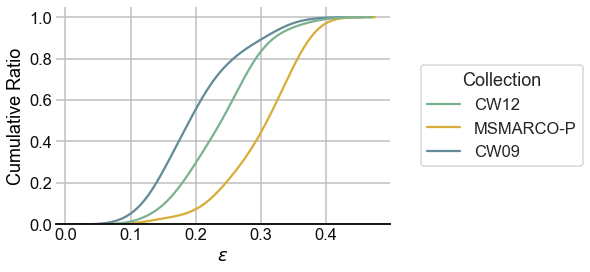

In [34]:
ax = sns.kdeplot(
    data = (
        pd.concat(data)
        .rename({"collection": "Collection"}, axis=1)
        .replace({
            "cw12": "CW12",
            "dl-passages": "MSMARCO-P",
            "cw09": "CW09"
        })
    ),
    x = "diff",
    hue = "Collection",
    fill = False,
    #stat="density",
    #element="step",
    cumulative = True,
    common_norm = False,
    palette=palette
)

ax.set_xlabel("$\epsilon$")
ax.set_ylabel("Cumulative Ratio")
# Put the legend out of the figure
sns.move_legend(ax, "center right", bbox_to_anchor=(1.6, 0.5))

ax.get_figure().savefig("../reports/figures/complementarity.pdf")

# Antisymmetry

In [6]:
data = []
for collection in COLLECTIONS:
    for model in MODELS:
        pointwise = PointwiseRunFile(f"../data/interim/pointwise/{collection}/mono_t5_{model}-run.txt")
        pairwise = PairwiseFileCache(
            f"../data/interim/pairwise/{collection}-{model}.parquet",
            depth=K,
            pointwise=pointwise
        )
        df = pairwise.cache.dropna().assign(collection=collection, model=model)
        df.score = df.score.apply(lambda x: np.exp(x))
        data.append(df)

df = pd.concat(data)

In [7]:
data = []
for _, (id_a, id_b, qid, score, collection, model) in df.iterrows():
    if score >= 0.5:
        data.append((id_a, id_b, qid, score, collection, model))
    else:
        data.append((id_b, id_a, qid, 1-score, collection, model))

df = pd.DataFrame(data, columns=("id_a", "id_b", "qid", "score", "collection", "model"))
df

,id_a,id_b,qid,score,collection,model
0,clueweb12-0401tw-00-05277,clueweb12-0401tw-00-05277,201,0.648757,cw12,3b
1,clueweb12-0401tw-00-05277,clueweb12-1100tw-72-06488,201,0.769899,cw12,3b
2,clueweb12-0401tw-00-05277,clueweb12-0300tw-49-08295,201,0.722788,cw12,3b
3,clueweb12-0401tw-00-05277,clueweb12-0500tw-17-18276,201,0.903938,cw12,3b
4,clueweb12-0401tw-00-05277,clueweb12-0717wb-19-18518,201,0.948825,cw12,3b
...,...,...,...,...,...,...
980472,clueweb09-en0004-14-19802,clueweb09-en0042-32-10247,200,0.989543,cw09,3b
980473,clueweb09-en0010-04-30917,clueweb09-en0042-32-10247,200,0.870584,cw09,3b
980474,clueweb09-en0042-32-10247,clueweb09-en0079-85-31855,200,0.696374,cw09,3b
980475,clueweb09-en0084-26-07774,clueweb09-en0042-32-10247,200,0.686408,cw09,3b


In [24]:
print(
    df
    .groupby(["collection", "model", "qid", "id_a", "id_b"])
    .count()
    .reset_index()
    .drop(["id_a", "id_b"], axis=1)
    .groupby(["collection", "model", "qid"])
    .value_counts()
    .reset_index()
    .groupby(["collection", "model", "qid"])
    .apply(lambda x: x.loc[x["score"] == 2, 0].values[0] / (x.loc[x["score"] == 1, 0].values[0] +x.loc[x["score"] == 2, 0].values[0]))
    .groupby(["collection", "model"])
    .describe()
    .reset_index()
    .loc[:, ["collection", "mean", "std", "min", "max"]]
    .to_latex(index=False)
)

\begin{tabular}{lrrrr}
\toprule
 collection &     mean &      std &      min &      max \\
\midrule
       cw09 & 0.311642 & 0.136570 & 0.054407 & 0.637197 \\
       cw12 & 0.382692 & 0.114779 & 0.120072 & 0.642576 \\
dl-passages & 0.497942 & 0.126409 & 0.135837 & 0.731449 \\
\bottomrule
\end{tabular}



/var/folders/54/8lplw84d1sbgcm1wmd2rgyd40000gn/T/ipykernel_16564/917238943.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df
